<a href="https://colab.research.google.com/github/vigneshwaran-dev/CV-research-timeline/blob/main/RCNN/rcnn-vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar

--2021-06-11 12:39:04--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2021-06-11 12:39:04--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  72.8MB/s    in 6.3s    

2021-06-11 12:39:10 (69.8 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



In [ ]:
!tar -xvf VOCtrainval_06-Nov-2007.tar

In [36]:
!mkdir images
!mkdir images/foreground
!mkdir images/background
!mkdir images/train
!mkdir images/train/background
!mkdir images/train/foreground
!mkdir images/test
!mkdir images/test/background
!mkdir images/test/foreground

In [4]:
import tensorflow as tf
import cv2
import os

import xml.etree.ElementTree as et

In [5]:
selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [6]:
def get_iou(bbox1, bbox2):
    assert bbox1['x1'] < bbox1['x2']
    assert bbox1['y1'] < bbox1['y2']
    assert bbox2['x1'] < bbox2['x2']
    assert bbox2['y1'] < bbox2['y2']
    
    x_left = max(bbox1['x1'], bbox2['x1'])
    y_top = max(bbox1['y1'], bbox2['y1'])
    x_right = min(bbox1['x2'], bbox2['x2'])
    y_bottom = min(bbox1['y2'], bbox2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bbox1_area = (bbox1['x2'] - bbox1['x1']) * (bbox1['y2'] - bbox1['y1'])
    bbox2_area = (bbox2['x2'] - bbox2['x1']) * (bbox2['y2'] - bbox2['y1'])
    iou = intersection_area / float(bbox1_area + bbox2_area - intersection_area)
    
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [7]:
path = 'VOCdevkit/VOC2007/JPEGImages'
annot = 'VOCdevkit/VOC2007/Annotations'
foreground = 'images/foreground'
background = 'images/background'

In [ ]:
# This is a time taking process. Takes around 4 hours on cpu. 
# If you are not patient, I have made the final images available. Download it extract it.

for e,i in enumerate(os.listdir(annot)):
  try:
    filename = i.split('.')[0] + '.jpg'
    print(e, filename)
    
    image = cv2.imread(os.path.join(path, filename))
    tree = et.parse(os.path.join(annot, i))
    
    root = tree.getroot()
    gtvalues=[]
    
    # get ground truth boxes
    for obj in root.findall('object'):
      if obj.find('name').text == 'person':
        x1 = int(obj.find('bndbox').find('xmin').text)
        y1 = int(obj.find('bndbox').find('ymin').text)
        x2 = int(obj.find('bndbox').find('xmax').text)
        y2 = int(obj.find('bndbox').find('ymax').text)
        gtvalues.append({'x1':x1,
                         'x2':x2,
                         'y1':y1,
                         'y2':y2})
    
    # generate regions from each image with selective search
    selective_search.setBaseImage(image)
    selective_search.switchToSelectiveSearchFast()
    selective_search_results = selective_search.process()
    
    imout = image.copy()
    counter = 0
    falsecounter = 0
    flag = 0
    fflag = 0
    bflag = 0
    
    for e, result in enumerate(selective_search_results):
        if e < 2000 and flag == 0:
            for gtval in gtvalues:
                x, y, w, h = result
                
                iou = get_iou(gtval,{'x1':x,
                                     'x2':x+w,
                                     'y1':y,
                                     'y2':y+h})
                
                if counter < 30:
                    if iou > 0.70: # foreground class
                        timage = imout[y:y+h, x:x+w]
                        resized = cv2.resize(timage, (224,224), interpolation=cv2.INTER_AREA)
                        cv2.imwrite(os.path.join(foreground, str(counter) + '-' + filename), resized) # save to another directory
                        counter += 1
                
                else :
                    fflag = 1
                
                if falsecounter < 30:
                    if iou < 0.3: # background class
                        timage = imout[y:y+h, x:x+w]
                        resized = cv2.resize(timage, (224,224), interpolation=cv2.INTER_AREA)
                        cv2.imwrite(os.path.join(background, str(counter) + '-' + filename), resized) # save to another directory
                        falsecounter += 1
                
                else :
                    bflag = 1
            
            if fflag == 1 and bflag == 1:
                print('inside')
                flag = 1
  
  except Exception as e:
      print(e)
      print('Error in' + filename)
      continue

In [ ]:
# !zip -r images.zip images

In [34]:
# wake me up when it reaches 5000. Dont forget please. If i dont continue 4 hrs is wasted

print(len(os.listdir(foreground)))
print(len(os.listdir(background)))

16550
2183


In [37]:
import shutil

for i, file in enumerate(os.listdir(background)):
  if i < 1600:
    shutil.copy(os.path.join(background, file), os.path.join('images/train/background', file))
  
  elif i < 2100:
    shutil.copy(os.path.join(background, file), os.path.join('images/test/background', file))
  
  else:
    break
  

for i, file in enumerate(os.listdir(foreground)):
  if i < 1600:
    shutil.copy(os.path.join(foreground, file), os.path.join('images/train/foreground', file))
  
  elif i < 2100:
    shutil.copy(os.path.join(foreground, file), os.path.join('images/test/foreground', file))
  
  else:
    break

print(len(os.listdir('images/train/background')))
print(len(os.listdir('images/train/foreground')))
print(len(os.listdir('images/test/background')))
print(len(os.listdir('images/test/foreground')))

1600
1600
500
500


In [38]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.vgg16 import VGG16

In [39]:
vggmodel = VGG16(weights='imagenet', include_top = True)

for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

X= vggmodel.layers[-2].output
predictions = Dense(1, activation='sigmoid')(X)
model = Model(vggmodel.input, predictions)

model.compile(loss=tf.keras.losses.binary_crossentropy, 
                    optimizer=Adam(learning_rate=0.0001),
                    metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [40]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('images/train',
                                                               validation_split=0.2,
                                                               subset='training',
                                                               seed=0,
                                                               image_size=(224, 224),
                                                               batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory('images/test',
                                                             validation_split=0.2,
                                                             subset='validation',
                                                             seed=0,
                                                             image_size=(224, 224),
                                                             batch_size=32)

Found 3200 files belonging to 2 classes.
Using 2560 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.


In [41]:
print(train_ds.class_names)
print(val_ds.class_names)

['background', 'foreground']
['background', 'foreground']


In [42]:
callback = tf.keras.callbacks.ModelCheckpoint('checkpoints/{epoch}',
                                              save_weights_only=True,
                                              save_best_only=True)

In [43]:
# This cells takes hours to run.
# Or load weights
# model_final.load_weights('checkpoints/1')

model.fit(train_ds,
          validation_data=val_ds,
          epochs=5, 
          callbacks=[callback])

Epoch 1/5
80/80 [==============================] - 1109s 14s/step - loss: 0.3083 - accuracy: 0.8926 - val_loss: 0.2409 - val_accuracy: 0.9300
Epoch 2/5
80/80 [==============================] - 1118s 14s/step - loss: 0.1314 - accuracy: 0.9535 - val_loss: 0.2881 - val_accuracy: 0.9550
Epoch 3/5
80/80 [==============================] - 1103s 14s/step - loss: 0.0819 - accuracy: 0.9695 - val_loss: 0.2630 - val_accuracy: 0.9300
Epoch 4/5
80/80 [==============================] - 1112s 14s/step - loss: 0.0748 - accuracy: 0.9805 - val_loss: 0.3331 - val_accuracy: 0.9400
Epoch 5/5
80/80 [==============================] - 1104s 14s/step - loss: 0.0426 - accuracy: 0.9824 - val_loss: 0.6333 - val_accuracy: 0.9250


In [49]:
# !zip -r checkpoints.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/1.index (deflated 71%)
  adding: checkpoints/checkpoint (deflated 34%)
  adding: checkpoints/1.data-00000-of-00001 (deflated 12%)


In [45]:
import matplotlib.pyplot as plt
import numpy as np

gambar_tes = plt.imread('images/train/foreground/0-000173.jpg')
gambar_tes = np.expand_dims(gambar_tes, axis=0)

result = model.predict(gambar_tes)
print(result)

[[1.]]


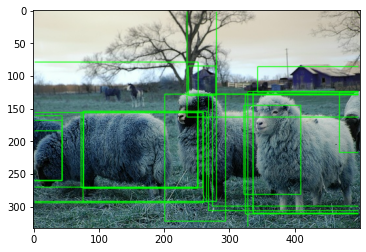

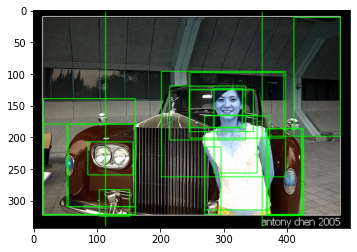

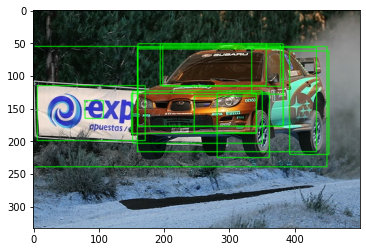

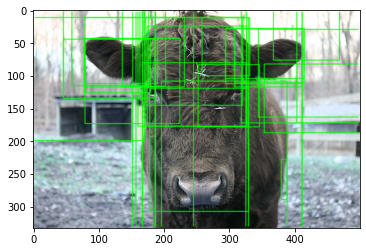

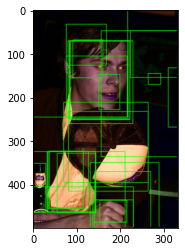

In [47]:
for e, i in enumerate(os.listdir(path)):
  if e < 5:
    img = cv2.imread(os.path.join(path, i))
    selective_search.setBaseImage(img)
    selective_search.switchToSelectiveSearchFast()
    selective_search_results = selective_search.process()
    imout = img.copy()
    
    for ex, result in enumerate(selective_search_results):
      if ex < 500:
        x, y, w, h = result
        timage = imout[y:y+h, x:x+w]
        resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis = 0)
        out = model.predict(img)
        
        if out[0][0] > 0.7:
          cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    
    plt.figure()
    plt.imshow(imout)
  
  else:
    break